In [33]:
# -------- CELL 1: IMPORT LIBRARIES --------
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [34]:
# -------- CELL 2: LOAD DATASET --------
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
labels_path = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_path = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Load labels and class info
labels_df = pd.read_csv(labels_path)
class_info_df = pd.read_csv(class_info_path)

# Merge dataframes
merged_df = pd.merge(labels_df, class_info_df, on='patientId')

# Simplify labels
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple["patientId"] = labels_simple["patientId"].astype(str) + ".dcm"

print("✅ Dataset loaded and preprocessed!")

✅ Dataset loaded and preprocessed!


In [35]:
# -------- CELL 3: PREPARE TFRECORDS --------
def serialize_example(image, label):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

# Create TFRecords
tfrecord_path = "/kaggle/working/pneumonia_data.tfrecords"
with tf.io.TFRecordWriter(tfrecord_path) as writer:
    for idx, row in labels_simple.iterrows():
        dicom = pydicom.dcmread(os.path.join(dataset_path, "stage_2_train_images", row['patientId']))
        img = dicom.pixel_array.astype(np.float32)
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
        img = np.stack([img]*3, axis=-1)  # Convert to 3-channel
        label = 1 if row['Target'] == 'Pneumonia' else 0
        example = serialize_example(img, label)
        writer.write(example)

print("✅ TFRecords created at:", tfrecord_path)

✅ TFRecords created at: /kaggle/working/pneumonia_data.tfrecords


In [ ]:
# -------- CELL 4: TF.DATA PIPELINE --------
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    image = tf.reshape(image, (128, 128, 3))  # Match preprocessing shape
    return image, example['label']

# Load dataset
dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

# Split into train/validation
train_size = int(0.8 * len(labels_simple))
train_data = dataset.take(train_size).shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_data = dataset.skip(train_size).batch(64).prefetch(tf.data.AUTOTUNE)

print("✅ Train/validation datasets created!")

In [38]:
# -------- CELL 5: INSPECT DATA PIPELINE --------
# Check a batch of training data
for images, labels in train_data.take(1):
    print("Image shape:", images.shape)  # Should be (64, 128, 128, 3)
    print("Labels:", labels.numpy())  # Should be 0s and 1s

# Check class distribution in training data
train_labels = []
for _, labels in train_data:
    train_labels.extend(labels.numpy())
print("Training Class Distribution:", pd.Series(train_labels).value_counts())

# Check class distribution in validation data
val_labels = []
for _, labels in val_data:
    val_labels.extend(labels.numpy())
print("Validation Class Distribution:", pd.Series(val_labels).value_counts())

Image shape: (64, 128, 128, 3)
Labels: [0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1]
Training Class Distribution: 0    16319
1     5028
Name: count, dtype: int64
Validation Class Distribution: 0    4353
1     984
Name: count, dtype: int64


In [39]:
# -------- CELL 6: ADJUST CLASS WEIGHTS --------
normal_count = labels_simple['Target'].value_counts()['Normal']
pneumonia_count = labels_simple['Target'].value_counts()['Pneumonia']
total = normal_count + pneumonia_count

# Adjust class weights
class_weights = {
    0: (1 / normal_count) * (total / 2),  # Weight for "Normal"
    1: (1 / pneumonia_count) * (total / 2)  # Weight for "Pneumonia"
}

print("Class Weights:", class_weights)

Class Weights: {0: 0.6454140866873065, 1: 2.2192282102461744}


In [43]:
# -------- CELL 7: BUILD AND COMPILE MODEL --------
# Define input tensor
input_tensor = tf.keras.Input(shape=(128, 128, 3), name="input_layer")

# Load EfficientNetB0
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)
base_model.trainable = False  # Freeze layers

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# # Compile
# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
# )

# model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [45]:
# -------- CELL 18: UNFREEZE BASE MODEL LAYERS --------
base_model.trainable = True  # Unfreeze all layers

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc', 'recall']
)

print("✅ Base model unfrozen and recompiled!")

✅ Base model unfrozen and recompiled!


In [46]:
# -------- CELL 9: RETRAIN THE MODEL --------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)]
)

print("✅ Model retrained!")

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 124s 201ms/step - accuracy: 0.5695 - auc: 0.6483 - loss: 0.6954 - recall: 0.6920 - val_accuracy: 0.6828 - val_auc: 0.5791 - val_loss: 0.6696 - val_recall: 0.3364
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.6878 - auc: 0.7808 - loss: 0.5925 - recall: 0.7808 - val_accuracy: 0.3067 - val_auc: 0.4774 - val_loss: 0.7863 - val_recall: 0.7602
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.7055 - auc: 0.8029 - loss: 0.5706 - recall: 0.7957 - val_accuracy: 0.6736 - val_auc: 0.8198 - val_loss: 0.5846 - val_recall: 0.8526
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.7217 - auc: 0.8225 - loss: 0.5425 - recall: 0.8073 - val_accuracy: 0.7056 - val_auc: 0.8334 - val_loss: 0.5500 - val_recall: 0.8343
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.7274 - auc: 0.8312 - loss: 0.5347 - recall: 0.8090 - val_accuracy: 0.7107 - val_auc: 0.8372 - val_loss: 0.5422 - val_recall: 0

In [47]:
# -------- CELL 10: EVALUATE THE MODEL --------
val_loss, val_acc, val_auc, val_recall = model.evaluate(val_data, verbose=0)
print(f"Validation AUC: {val_auc:.3f}")
print(f"Validation Recall: {val_recall:.3f}")

Validation AUC: 0.853
Validation Recall: 0.837


In [ ]:
# -------- CELL 10: SAVE THE MODEL --------
model.save("/kaggle/working/pneumonia_detection_model.keras")
print("✅ Model saved!")

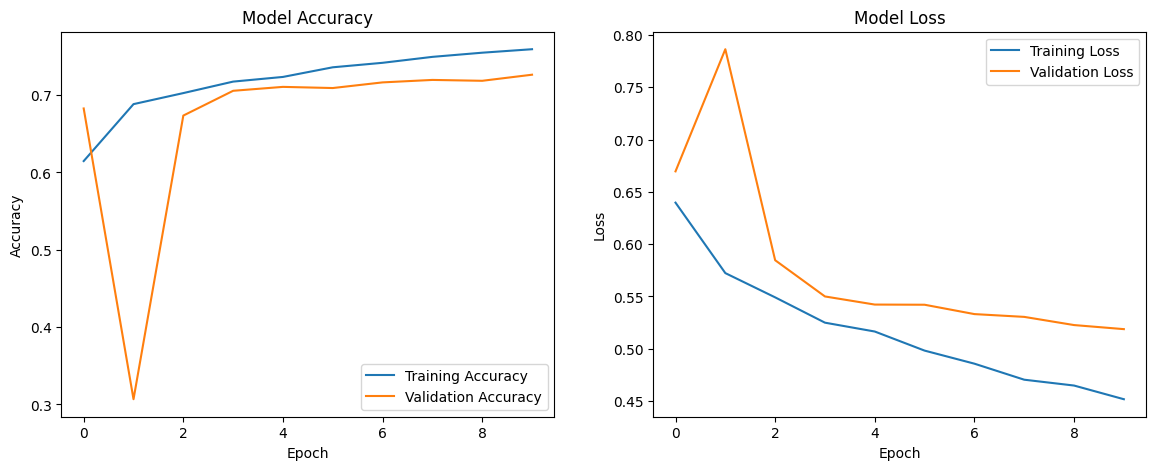

In [64]:
# -------- CELL: VISUALIZE LEARNING CURVES --------
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [51]:
# # -------- CELL 12: TEST ON NEW IMAGE --------
# def predict_pneumonia(patient_id):
#     # Load DICOM file
#     dicom_path = os.path.join(dataset_path, "stage_2_train_images", f"{patient_id}.dcm")
#     dicom = pydicom.dcmread(dicom_path)
#     img = dicom.pixel_array.astype(np.float32)
    
#     # Preprocess
#     img = cv2.resize(img, (128, 128))
#     img = (img - np.min(img)) / (np.max(img) - np.min(img))
#     img = np.stack([img]*3, axis=-1)  # Convert to 3-channel
    
#     # Predict
#     pred_prob = model.predict(img[np.newaxis, ...])[0][0]
#     return pred_prob

# # Example (use a real patient ID)
# patient_id = "0004cfab-14fd-4e49-80ba-63a80b6bddd6"  # Replace with your ID

# # Get ground truth label
# ground_truth_label = labels_simple[labels_simple['patientId'] == patient_id + ".dcm"]['Target'].values[0]
# ground_truth = "Pneumonia" if ground_truth_label == 1 else "Normal"

# # Get model prediction
# pred_prob = predict_pneumonia(patient_id)
# prediction = "Pneumonia" if pred_prob > 0.5 else "Normal"

# # Print results
# print(f"Patient ID: {patient_id}")
# print(f"Ground Truth: {ground_truth}")
# print(f"Model Prediction: {prediction} (Probability: {pred_prob:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Ground Truth: Normal
Model Prediction: Normal (Probability: 0.26)


In [53]:
# pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [63]:
# -------- CELL 12: FIXED INTERACTIVE TESTING WIDGET --------
import ipywidgets as widgets
from IPython.display import display
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pydicom

# Prepare validation patient IDs without ".dcm"
val_patient_ids = labels_simple.iloc[val_idx]['patientId'].str.replace(".dcm", "").tolist()

# Output widget
output = widgets.Output()

def show_patient(patient_id):
    """Display patient image with prediction, ground truth, and bounding box (if pneumonia)."""
    with output:
        output.clear_output(wait=True)
        try:
            # Validate patient ID
            if patient_id not in val_patient_ids:
                print(f"Patient ID '{patient_id}' is not in the validation set.")
                return

            # Fetch patient data correctly (without '.dcm' conflict)
            patient_data = merged_df[merged_df['patientId'].str.replace(".dcm", "") == patient_id]

            if patient_data.empty:
                print(f"No data found for patient ID '{patient_id}'.")
                return

            # Load and preprocess image
            full_id = patient_id + ".dcm"
            dicom_path = os.path.join(dataset_path, "stage_2_train_images", full_id)
            dicom = pydicom.dcmread(dicom_path)
            img = dicom.pixel_array
            img_resized = cv2.resize(img, (224, 224))
            img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())

            # Model prediction
            input_img = np.expand_dims(img_norm, axis=(0, -1))
            pred_prob = model.predict(input_img)[0][0]
            pred_label = "Pneumonia" if pred_prob > 0.5 else "Normal"

            # Ground truth
            target = patient_data['Target'].values[0]
            class_label = patient_data['class'].values[0]

            # Visualization
            plt.figure(figsize=(10, 6))

            if target == 1:
                # Original bounding box
                x, y, w, h = patient_data[['x', 'y', 'width', 'height']].iloc[0].astype(int)

                # Adjust bounding box for resized image
                scale_x, scale_y = 224 / img.shape[1], 224 / img.shape[0]
                x, y, w, h = int(x * scale_x), int(y * scale_y), int(w * scale_x), int(h * scale_y)

                # Draw bounding box
                img_rgb = np.stack([img_norm]*3, axis=-1)
                cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (1, 0, 0), 2)
                plt.imshow(img_rgb)
            else:
                plt.imshow(img_norm, cmap='gray')

            plt.title(f"Prediction: {pred_label} ({pred_prob:.2f}) | Ground Truth: {class_label}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error loading patient '{patient_id}': {str(e)}")

def random_patient(b):
    """Randomly select a patient from validation set."""
    rand_id = random.choice(val_patient_ids)
    patient_id_widget.value = rand_id
    show_patient(rand_id)

# Widgets setup
patient_id_widget = widgets.Text(
    value=random.choice(val_patient_ids),
    description="Patient ID:",
    layout={'width': '400px'}
)
patient_id_widget.on_submit(lambda x: show_patient(patient_id_widget.value))

random_button = widgets.Button(description="Next Random Patient")
random_button.on_click(random_patient)

# Display the widgets
widget_ui = widgets.VBox([widgets.HBox([patient_id_widget, random_button]), output])
display(widget_ui)

# Display the initial patient
show_patient(patient_id_widget.value)


In [67]:
# ---- CHECK LAYER NAMES IN base_model ----
for layer in base_model.layers[::-1]:
    if 'conv' in layer.name:
        print("Last convolutional layer:", layer.name)
        break


Last convolutional layer: top_conv


#  Grad-CAM